In [1]:
import numpy as np
import struct
from Network2 import Network
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import os

In [2]:

def load_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        if magic != 2051:
            raise ValueError(f'Invalid magic number {magic} in image file: {file_path}')
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows * cols)
        images = images.astype(np.float32) / 255.0 
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        if magic != 2049:
            raise ValueError(f'Invalid magic number {magic} in label file: {file_path}')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = load_images('data/FashionMNIST/raw/train-images-idx3-ubyte')
train_labels = load_labels('data/FashionMNIST/raw/train-labels-idx1-ubyte')
test_images = load_images('data/FashionMNIST/raw/t10k-images-idx3-ubyte')
test_labels = load_labels('data/FashionMNIST/raw/t10k-labels-idx1-ubyte')


def create_batches(images, labels, batch_size=64, shuffle=True):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield images[batch_indices], labels[batch_indices]

batch_size = 64


train_loader = list(create_batches(train_images, train_labels, batch_size=batch_size, shuffle=True))
test_loader = list(create_batches(test_images, test_labels, batch_size=batch_size, shuffle=False))

def count_batches(generator):
    count = 0
    for _ in generator:
        count += 1
    return count

## Architecture 1

Epoch 1, Cost: 68.26042868676339, Accuracy: 78.32833333333333%
Epoch 1, Cost: 50.29145748643503, Accuracy: 82.64%
Epoch 1, F1 Score: 82.48265318567174%
Epoch 2, Cost: 45.139058960325926, Accuracy: 85.29166666666667%
Epoch 2, Cost: 44.38562850547425, Accuracy: 84.04%
Epoch 2, F1 Score: 83.91179373840475%
Epoch 3, Cost: 40.37288699582932, Accuracy: 86.68%
Epoch 3, Cost: 41.60434243136768, Accuracy: 84.91%
Epoch 3, F1 Score: 84.77905143304922%
Epoch 4, Cost: 37.49195027840224, Accuracy: 87.53333333333333%
Epoch 4, Cost: 39.879541110635124, Accuracy: 85.8%
Epoch 4, F1 Score: 85.67669081030441%
Epoch 5, Cost: 35.387341369676086, Accuracy: 88.10166666666667%
Epoch 5, Cost: 38.59404067376101, Accuracy: 86.23%
Epoch 5, F1 Score: 86.13566362736177%
Epoch 6, Cost: 33.71455775139688, Accuracy: 88.565%
Epoch 6, Cost: 37.61220044904448, Accuracy: 86.46%
Epoch 6, F1 Score: 86.37911137043956%
Epoch 7, Cost: 32.27856774417992, Accuracy: 89.01%
Epoch 7, Cost: 36.84855647918063, Accuracy: 86.72%
Epoch 7

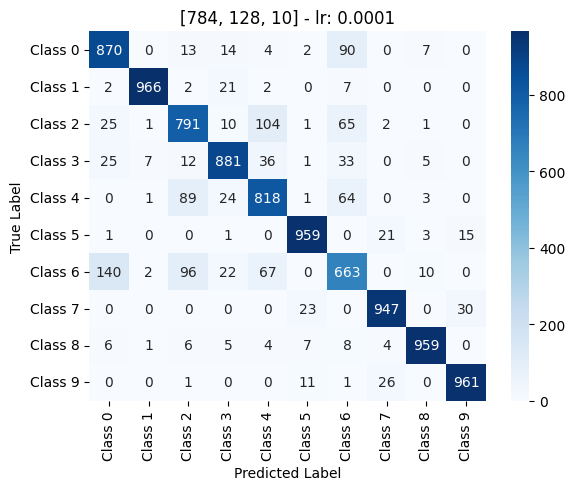

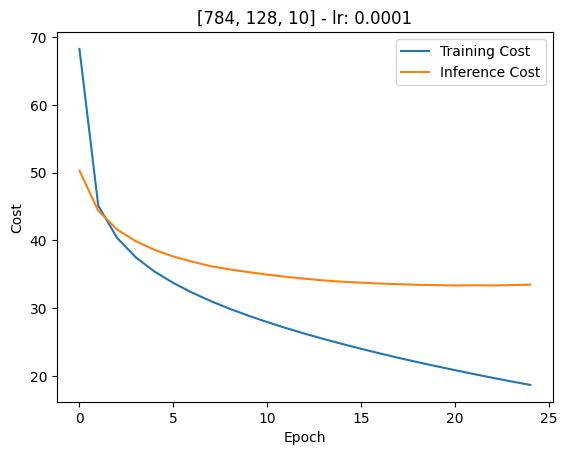

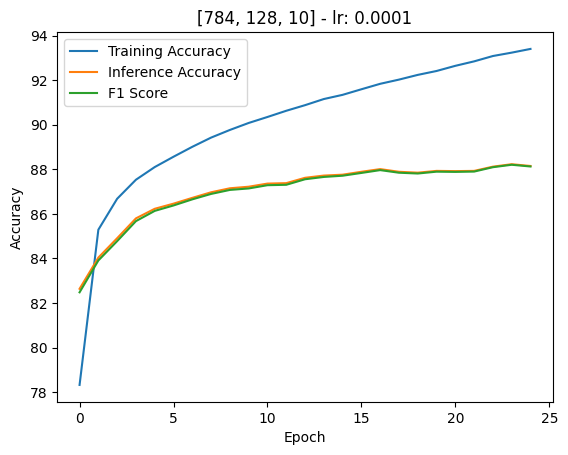

Parameters saved successfully at 'models/final_1.pkl'
Cost: 33.46354127244102
Accuracy: 88.15%
F1 Score: 88.12738504907611%


In [3]:
layers = [784, 128, 10]  # Example layer sizes
network = Network(layers, drop_out=0.3, learning_rate=0.0001)

os.makedirs('models', exist_ok=True)
save_path = 'models/final_1.pkl'

# Training loop
train_costs = []
train_accuracies = []

infer_cost = []
infer_accuracies = []

val_labels = []
val_predictions = []

f1_scores = []

for epoch in range(25):
    correct_train = 0
    total_train = 0
    epoch_cost_train = 0

    val_labels = []
    val_predictions = []

    for images, labels in train_loader:
        labels_one_hot = np.eye(10)[labels]
        network.forward(images)
        cost = network.calculateCost(labels_one_hot)
        network.backward(labels_one_hot)
        predictions = network.classify(images)
        correct_train += np.sum(predictions == labels)
        total_train += len(labels)
        epoch_cost_train += cost

    avg_cost_train = 100 * epoch_cost_train /len(train_loader)
    train_costs.append(avg_cost_train)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    correct_infer = 0
    total_infer = 0
    epoch_cost_infer = 0

    for images, labels in test_loader:
        outputs = network.classify(images)
        correct_infer += np.sum(outputs == labels)
        labels_one_hot = np.eye(10)[labels]
        cost = network.calculateCost(labels_one_hot)
        total_infer += len(labels)
        epoch_cost_infer += cost

        val_labels.extend(labels)
        val_predictions.extend(outputs)
    
    avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
    print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {train_accuracy}%')
    infer_cost.append(avg_cost_test)

    infer_accuracy = 100 * correct_infer / total_infer
    print(f'Epoch {epoch+1}, Cost: {avg_cost_test}, Accuracy: {infer_accuracy}%')
    infer_accuracies.append(infer_accuracy)

    f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
    print(f'Epoch {epoch+1}, F1 Score: {f1}%')
    f1_scores.append(f1)
    
    # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

class_names = [f'Class {i}' for i in range(10)]
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.show()

plt.plot(train_costs, label='Training Cost')
plt.plot(infer_cost, label='Inference Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(infer_accuracies, label='Inference Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.legend()
plt.show()


network.save_parameters(save_path)
print(f"Parameters saved successfully at '{save_path}'")
network2 = Network(layers, drop_out=0.3, learning_rate=0.0001)
network2.load_parameters(save_path)

correct_infer = 0
total_infer = 0
epoch_cost_infer = 0

for images, labels in test_loader:
    outputs = network.classify(images)
    correct_infer += np.sum(outputs == labels)
    labels_one_hot = np.eye(10)[labels]
    cost = network.calculateCost(labels_one_hot)
    total_infer += len(labels)
    epoch_cost_infer += cost

    val_labels.extend(labels)
    val_predictions.extend(outputs)

avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
print(f'Cost: {avg_cost_test}')

infer_accuracy = 100 * correct_infer / total_infer
print(f'Accuracy: {infer_accuracy}%')

f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
print(f'F1 Score: {f1}%')


Epoch 1, Cost: 75.02630059380597, Accuracy: 77.11166666666666%
Epoch 1, Cost: 51.00518757693739, Accuracy: 82.41%
Epoch 1, F1 Score: 82.37893587037662%
Epoch 2, Cost: 45.983919881170024, Accuracy: 85.365%
Epoch 2, Cost: 43.382208234033975, Accuracy: 84.52%
Epoch 2, F1 Score: 84.51035977725286%
Epoch 3, Cost: 39.59260113184136, Accuracy: 87.13833333333334%
Epoch 3, Cost: 40.17903787602117, Accuracy: 85.54%
Epoch 3, F1 Score: 85.54738728359554%
Epoch 4, Cost: 35.85632914082141, Accuracy: 88.14333333333333%
Epoch 4, Cost: 38.30002982332641, Accuracy: 86.13%
Epoch 4, F1 Score: 86.12564597349474%
Epoch 5, Cost: 33.18987963423577, Accuracy: 88.95166666666667%
Epoch 5, Cost: 37.009828557727324, Accuracy: 86.7%
Epoch 5, F1 Score: 86.67891669497598%
Epoch 6, Cost: 31.114105516927495, Accuracy: 89.525%
Epoch 6, Cost: 36.130110889742255, Accuracy: 86.99%
Epoch 6, F1 Score: 86.95846306560469%
Epoch 7, Cost: 29.401134604445133, Accuracy: 90.02166666666666%
Epoch 7, Cost: 35.53994995347439, Accuracy

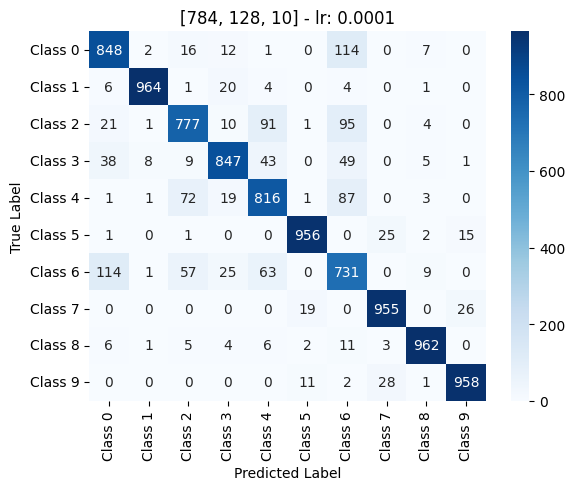

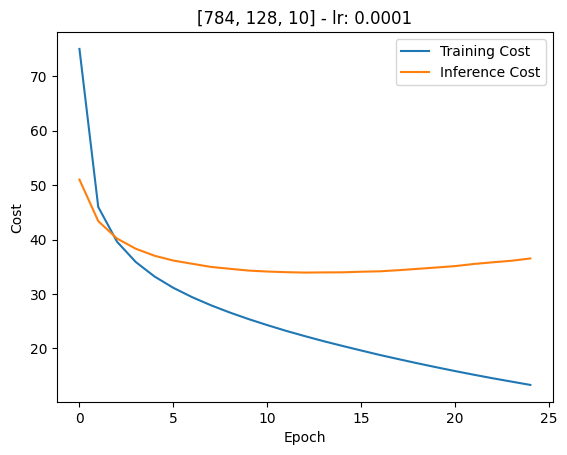

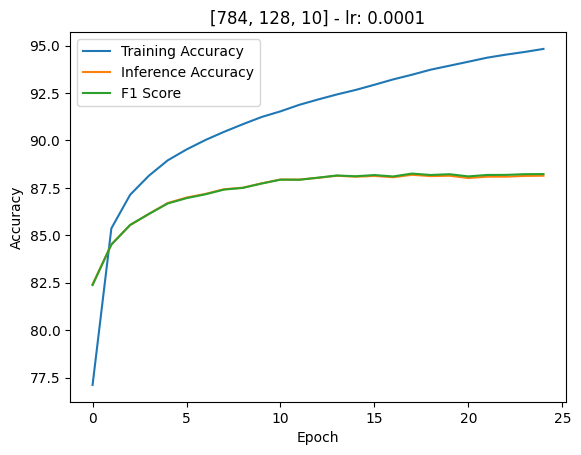

Parameters saved successfully at 'models/final_2.pkl'
Cost: 36.516657566435654
Accuracy: 88.14%
F1 Score: 88.22860948418374%


In [4]:
layers = [784, 128, 64, 10]  # Example layer sizes
network = Network(layers, drop_out=0.3, learning_rate=0.0001)

os.makedirs('models', exist_ok=True)
save_path = 'models/final_2.pkl'

# Training loop
train_costs = []
train_accuracies = []

infer_cost = []
infer_accuracies = []

val_labels = []
val_predictions = []

f1_scores = []

for epoch in range(25):
    correct_train = 0
    total_train = 0
    epoch_cost_train = 0

    val_labels = []
    val_predictions = []

    for images, labels in train_loader:
        labels_one_hot = np.eye(10)[labels]
        network.forward(images)
        cost = network.calculateCost(labels_one_hot)
        network.backward(labels_one_hot)
        predictions = network.classify(images)
        correct_train += np.sum(predictions == labels)
        total_train += len(labels)
        epoch_cost_train += cost

    avg_cost_train = 100 * epoch_cost_train /len(train_loader)
    train_costs.append(avg_cost_train)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    correct_infer = 0
    total_infer = 0
    epoch_cost_infer = 0

    for images, labels in test_loader:
        outputs = network.classify(images)
        correct_infer += np.sum(outputs == labels)
        labels_one_hot = np.eye(10)[labels]
        cost = network.calculateCost(labels_one_hot)
        total_infer += len(labels)
        epoch_cost_infer += cost

        val_labels.extend(labels)
        val_predictions.extend(outputs)
    
    avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
    print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {train_accuracy}%')
    infer_cost.append(avg_cost_test)

    infer_accuracy = 100 * correct_infer / total_infer
    print(f'Epoch {epoch+1}, Cost: {avg_cost_test}, Accuracy: {infer_accuracy}%')
    infer_accuracies.append(infer_accuracy)

    f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
    print(f'Epoch {epoch+1}, F1 Score: {f1}%')
    f1_scores.append(f1)
    
    # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

class_names = [f'Class {i}' for i in range(10)]
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.show()

plt.plot(train_costs, label='Training Cost')
plt.plot(infer_cost, label='Inference Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(infer_accuracies, label='Inference Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('[784, 128, 10] - lr: 0.0001')
plt.legend()
plt.show()


network.save_parameters(save_path)
print(f"Parameters saved successfully at '{save_path}'")
network2 = Network(layers, drop_out=0.3, learning_rate=0.0001)
network2.load_parameters(save_path)

correct_infer = 0
total_infer = 0
epoch_cost_infer = 0

for images, labels in test_loader:
    outputs = network.classify(images)
    correct_infer += np.sum(outputs == labels)
    labels_one_hot = np.eye(10)[labels]
    cost = network.calculateCost(labels_one_hot)
    total_infer += len(labels)
    epoch_cost_infer += cost

    val_labels.extend(labels)
    val_predictions.extend(outputs)

avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
print(f'Cost: {avg_cost_test}')

infer_accuracy = 100 * correct_infer / total_infer
print(f'Accuracy: {infer_accuracy}%')

f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
print(f'F1 Score: {f1}%')


In [5]:
# layers = [784, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0004)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 10] - lr: 0.0004')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

In [6]:
# layers = [784, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0002)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 10] - lr: 0.0002')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

In [7]:
# layers = [784, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0001)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 10] - lr: 0.0001')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 10] - lr: 0.0001')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 10] - lr: 0.0001')
# plt.legend()
# plt.show()

## Architecture 2

In [8]:
# layers = [784, 128, 64, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0005)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 64, 10] - lr: 0.0005')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 64, 10] - lr: 0.0005')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 64, 10] - lr: 0.0005')
# plt.legend()
# plt.show()

In [9]:
# layers = [784, 128, 64, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0004)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 64, 10] - lr: 0.0004')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 64, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 64, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

In [10]:
# layers = [784, 128, 64, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0002)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 64, 10] - lr: 0.0002')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 64, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 64, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

In [11]:
# layers = [784, 128, 64, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0001)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 128, 64, 10] - lr: 0.0001')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 128, 64, 10] - lr: 0.0001')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 128, 64, 10] - lr: 0.0001')
# plt.legend()
# plt.show()

## Architecture 3

In [12]:
# layers = [784, 1024, 512, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0005)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0005')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0005')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0005')
# plt.legend()
# plt.show()

In [13]:
# layers = [784, 1024, 512, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0004)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0004')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0004')
# plt.legend()
# plt.show()

In [14]:
# layers = [784, 1024, 512, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0002)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0002')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0002')
# plt.legend()
# plt.show()

In [15]:
# layers = [784, 1024, 512, 128, 10]  # Example layer sizes
# network = Network(layers, drop_out=0.3, learning_rate=0.0001)

# # Training loop
# train_costs = []
# train_accuracies = []

# infer_cost = []
# infer_accuracies = []

# val_labels = []
# val_predictions = []

# f1_scores = []

# for epoch in range(25):
#     correct_train = 0
#     total_train = 0
#     epoch_cost_train = 0

#     val_labels = []
#     val_predictions = []

#     for images, labels in train_loader:
#         labels_one_hot = np.eye(10)[labels]
#         network.forward(images)
#         cost = network.calculateCost(labels_one_hot)
#         network.backward(labels_one_hot)
#         predictions = network.classify(images)
#         correct_train += np.sum(predictions == labels)
#         total_train += len(labels)
#         epoch_cost_train += cost

#     avg_cost_train = 100 * epoch_cost_train /len(train_loader)
#     train_costs.append(avg_cost_train)

#     train_accuracy = 100 * correct_train / total_train
#     train_accuracies.append(train_accuracy)
    
#     correct_infer = 0
#     total_infer = 0
#     epoch_cost_infer = 0

#     for images, labels in test_loader:
#         outputs = network.classify(images)
#         correct_infer += np.sum(outputs == labels)
#         labels_one_hot = np.eye(10)[labels]
#         cost = network.calculateCost(labels_one_hot)
#         total_infer += len(labels)
#         epoch_cost_infer += cost

#         val_labels.extend(labels)
#         val_predictions.extend(outputs)
    
#     avg_cost_test = 100 * epoch_cost_infer / len(test_loader)
#     infer_cost.append(avg_cost_test)

#     infer_accuracy = 100 * correct_infer / total_infer
#     infer_accuracies.append(infer_accuracy)

#     f1 = 100* f1_score(val_labels, val_predictions, average='weighted')
#     f1_scores.append(f1)
    
#     # print(f'Epoch {epoch+1}, Cost: {avg_cost_train}, Accuracy: {infer_accuracy}%')

# class_names = [f'Class {i}' for i in range(10)]
# cm = confusion_matrix(val_labels, val_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0001')
# plt.show()

# plt.plot(train_costs, label='Training Cost')
# plt.plot(infer_cost, label='Inference Cost')
# plt.xlabel('Epoch')
# plt.ylabel('Cost')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0001')
# plt.legend()
# plt.show()

# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(infer_accuracies, label='Inference Accuracy')
# plt.plot(f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('[784, 1024, 512, 128, 10] - lr: 0.0001')
# plt.legend()
# plt.show()